# NLP_State Gov Complaint / Question Classification Project

### Проект группы развития медиааналитики в г. Москва

## Задача

Необходимо обучить модель, которая будет присваивать сообщениям пользователей класс - *жалоба / вопрос.*

## Методология проекта

1. Сделать первичную обработку данных.
2. Обучить модели классификации, начиная с baselines.
3. Оценить качество классификации разных моделей по метрикам качества выбрать лучшую.
4. Сделать выводы.

## Данные

В качестве данных предложен файл, содержащий в себе вопросы в адрес государственных и муниципальных органов, которые пользователи оставили в социальных сетях. Файл с данными находиться [здесь](https://docs.google.com/spreadsheets/d/1VoONQ5Li6hYFv1SGmUKEWdnm7wYDmWYi/edit?usp=sharing&ouid=117398067332429699807&rtpof=true&sd=true).


In [1]:
import nltk
import pandas as pd

from functools import lru_cache

import fasttext.util
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров

from sklearn.pipeline import Pipeline

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

from tqdm import tqdm
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import warnings

import matplotlib.pyplot as plt
import numpy as np
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from functools import lru_cache

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from pymystem3 import Mystem
from multiprocessing import Pool
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading pa

In [2]:
# в nltk много токенизаторов
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer']

In [3]:
from nltk.corpus import stopwords

# смотрим, какие языки есть
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [4]:
# выведем все стоп-слова русского языка
sw = stopwords.words('russian')
print(sw)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

## Загрузка и изучение данных

In [5]:
df = pd.read_excel("C:\\Users\\HOME\\PycharmProjects\\Data_scientist_NLP_данные.xlsx")
df.head(20)

,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что..."


In [6]:
df.columns

Index(['Дата', 'Категория', 'Тема', 'Муниципалитет', 'Текст'], dtype='object')

In [7]:
# rename the columns
d = df.rename(columns={'Категория': 'category',
                        'Тема': 'topic',
                        'Муниципалитет': 'municipality',
                        'Текст': 'text',
                       'Дата': 'date'})

# print the DataFrame to verify the column names
print(d.columns)
d

Index(['date', 'category', 'topic', 'municipality', 'text'], dtype='object')


,date,category,topic,municipality,text
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


### Изучим целевую переменную label на предмет дисбаланса

С дисбалансом таргета можно бороться разными способами:
* провести upsampling, downsampling;
* добавить при обучении модели аргумент ```class_weight = 'balanced'```

В данном проекте мы будем использовать второй способ; в целях тренировки сделаем downsampling.

In [8]:
d['category'].unique()

array(['Вопрос', 'Жалоба'], dtype=object)

In [9]:
# проверка таргета на дисбаланс
d['category'].value_counts()

Вопрос    24549
Жалоба     5000
Name: category, dtype: int64

In [10]:
d['category'].value_counts() / (len(df))

Вопрос    0.83079
Жалоба    0.16921
Name: category, dtype: float64

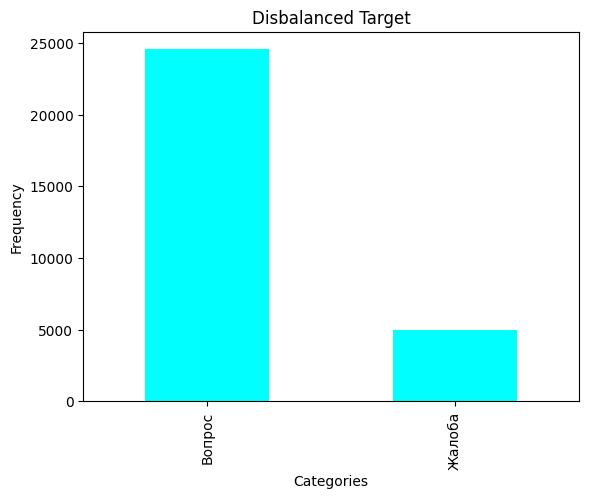

In [11]:
d['category'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

In [12]:
# перекодируем таргет цифрами
d['label'] = d['category'].replace({'Вопрос': 'question', 'Жалоба': 'complaint'})
d.head(10)

,date,category,topic,municipality,text,label
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,question
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",question
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,question
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,question
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...",question
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,complaint
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,complaint
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",complaint
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,question
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...",question


### Изучим текстовые данные

In [13]:
corpus = list(d['text'])
corpus

["'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)",
 "'[id294938415:bp-88767010_4|Αнастасия], Здравствуйте, подскажите как оспорить результаты по отказу пособия с 8 до 17? Насчитали большую сумму, а по факту меньше. Как быть?спасибо",
 "'[club53367440:bp-53367440_121743|Министерство], здравствуйте. С 3 до 7 уже направили? Сегодня же только 14",
 "'Здравствуйте когда будет выплата ДВ?",
 "'Девочки всем привет,у меня такой вопрос получила пособие вместо 12444,7 с копейками,детские вчера переоформила которые до 1,5,нам вчера исполнился 1 год,когда придет остальная часть?",
 "'Когда будет приведён в порядок пруд в центре Ивни по улице Луговая? Не просто покос рогоза в январе перед журналистами, а качественная чистка водоёма от рогоза, который превращает пруд в центре посёлка в болото и сборник мусора.",
 "'Обращаюсь от имени одиноких престарелых людей жителей микрорайона Лименды города Котласа. по поводу нововведения передачи

In [14]:
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)

    return lemm_text

def clear_text(text):
    clr = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    cleared_text = " ".join(clr.split())
    return cleared_text

In [15]:
# тестируем функции
print("Исходный текст:", corpus[153])
print()
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[153])))

Исходный текст: 'А,он будет ездить по старому маршруту,через ЛИСКИ,не подскажите???

Очищенный и лемматизированный текст: а он быть ездить по старый маршрут через лиски не подсказывать



In [16]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")


def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [17]:
print(d.text[0])

'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)


In [18]:
# # создаем новый список для хранения очищенных и лемматизированных текстов
# processed_corpus = []
#
# # проходим по каждому тексту в корпусе, применяем функции лемматизации и очистки текста
# for text in corpus:
#     processed_text = lemmatize(clear_text(text))
#     processed_corpus.append(processed_text)

#### Код выше - корректный, но ввиду большого объема данных циклом обходить весь корпус занимает много времени. Сам по себе Mystem() очень долгий. Нужно какое-то более оптимальное решение.

#### Метод ```@lru_cashe``` создает для функции lemmatize кэш указанного размера, что позволяет в целом ускорить лемматизацию текста (что очень полезно, так как лемматизация - ресурсоемкий процесс).

In [19]:
# create a MorphAnalyzer instance
m = MorphAnalyzer()

# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

# set up lemmatization cache
@lru_cache(maxsize=100000)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# define text preprocessing function
def clean_text(text):
    # extract words from text
    tokens = regex.findall(text.lower())

    # lemmatize the words
    lemmas = [lemmatize_word(token) for token in tokens]

    # remove stopwords and short words
    words = [word for word in lemmas if word not in mystopwords and len(word) > 3]

    return words

In [20]:
print(*clean_text(d.text[3]))

здравствуйте выплата


In [21]:
text = d.text[13]
cleaned_text = clean_text(text)
print(cleaned_text)

['вопрос', 'администрация', 'город', 'деньга', 'почему', 'содержание', 'животное']


#### Нам нужно предобработать большой объем текста, помимо кэширования может помочь распараллеливание, например, методом Pool библиотеки multiprocessing:

In [22]:
# %%time
# # N = 200
# # with Pool(4) as p:
# #     lemmas = list(tqdm(p.imap(clean_text, data['text']), total=N))
#
# with Pool(4) as p:
#     lemmas = list(tqdm(p.imap(clean_text, d['text']), total=len(d)))
#
# d['lemmas'] = lemmas
# d.sample(5)

Код выше - корректный, однако ввиду большого объема данных лемматизатизация проходит очень долго. Попробуем найти другое решение.

## Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [23]:
d.columns

Index(['date', 'category', 'topic', 'municipality', 'text', 'label'], dtype='object')

In [24]:
data = d[['text', 'label']]

In [25]:
train, test = train_test_split(data, test_size=0.2)

In [26]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [27]:
train.sample()

,text,label
13323,"'Добрый вечер,а почему детям с 3 до 7 ни каких...",question


In [28]:
test.sample()

,text,label
2773,'Вообщем дорогие мамочки! Челябинск чтз!<br>То...,question


In [29]:
y_train.sample()

,label
20253,question


In [30]:
y_test.sample()

,label
29533,question


In [31]:
y_test = y_test['label'].values
y_test

array(['question', 'question', 'question', ..., 'question', 'question',
       'question'], dtype=object)

In [32]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [33]:
bow = vec.fit_transform(train['text'])
bow

<23639x53207 sparse matrix of type '<class 'numpy.int64'>'
	with 463086 stored elements in Compressed Sparse Row format>

In [34]:
print(train.text[111])

'Скажите, пожалуйста, родителям сообщается, что препарат экспериментальный до декабря 2023 года согласно официальному реестру клинических исследований?


In [35]:
list(vec.vocabulary_.items())[:10]

[('подскажите', 33496),
 ('вам', 6873),
 ('нужны', 27016),
 ('медики', 22888),
 ('id459258221', 2745),
 ('сергей', 42774),
 ('линии', 21677),
 ('для', 12621),
 ('консультаций', 19854),
 ('как', 18191)]

In [36]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000не', 1),
 ('000р', 2),
 ('000т', 3),
 ('000тр', 4),
 ('001', 5),
 ('002', 6),
 ('004463', 7),
 ('008', 8),
 ('00ч', 9)]

In [37]:
list(vec.vocabulary_.keys())[:10]

['подскажите',
 'вам',
 'нужны',
 'медики',
 'id459258221',
 'сергей',
 'линии',
 'для',
 'консультаций',
 'как']

In [38]:
len(vec.vocabulary_.items())

53207

### Логистическая регрессия

In [39]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [40]:
# len(clf.coef_[0]) returns the length of the clf.coef_[0] array, which is equal to the number of features used in the model.
len(clf.coef_[0])

53207

In [41]:
bow_test = vec.transform(test['text'])
bow_test

<5910x53207 sparse matrix of type '<class 'numpy.int64'>'
	with 109865 stored elements in Compressed Sparse Row format>

In [42]:
pred = clf.predict(bow_test)
pred[:10]

array(['question', 'question', 'question', 'complaint', 'question',
       'question', 'question', 'question', 'question', 'question'],
      dtype=object)

In [43]:
accuracy_score(pred, y_test)

0.8609137055837564

In [44]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.44      0.64      0.52       707
    question       0.95      0.89      0.92      5203

    accuracy                           0.86      5910
   macro avg       0.70      0.76      0.72      5910
weighted avg       0.89      0.86      0.87      5910



### *Вывод:*

**В данном случае, безо всякой предобработки текста модель логистической регрессии делает предсказания с правильностью 86.5% (0.865).** Посмотрим повнимательнее на classification report.

* Модель достигает общей точности в 0,86, что означает, что она правильно предсказывает метки классов для 86% экземпляров в тестовом наборе.

* Класс question имеет гораздо большее значение support (количество экземпляров в тестовом наборе), чем класс complaint, что указывает на его более частое появление в тестовом наборе. Модель достигает высокой точности (0,95) и полноты (0,89) для класса question, что означает, что она правильно идентифицирует большинство экземпляров этого класса и не ошибается в классификации многих экземпляров как question.

* Класс complaint имеет более низкую точность (0,45) и полноту (0,65) по сравнению с классом question, что означает, что модель менее точно идентифицирует экземпляры этого класса. Это может быть вызвано несколькими причинами, такими как несбалансированность классов, недостаточное количество тренировочных данных или представление признаков, которое не так хорошо выделяет характеристики класса complaint, как это делает для класса question.

* Макро-усредненная F1-мера (0,73) ниже, чем взвешенная средняя F1-мера (0,88), что указывает на то, что производительность модели более сильно зависит от более крупного класса question. Это также может быть признаком несбалансированности классов или смещения модели в сторону большинства классов.

**В целом, отчет о классификации говорит о том, что модель хорошо справляется с классом ```question```, но могла бы получить дополнительные улучшения в классификации класса ```complaint```.**

#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [45]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form


# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]


# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [46]:
# тестируем обработку
%time clean_text(data.text[13])

CPU times: total: 0 ns
Wall time: 4.01 ms


'вопрос администрация город деньга почему содержание животное'

##### Функции работают, проводим препроцессинг для train и test выборок.

In [47]:
%%time
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 23639/23639 [00:54<00:00, 434.71it/s]

CPU times: total: 26.6 s
Wall time: 54.4 s


,text,label,lemmas
11616,"'Доброе утро, мамочки подскажите пожалуйста ка...",question,добрый утро мамочка подсказать пожалуйста посо...
21807,'Добрый день скажите пожалуйста для получения ...,question,добрый день сказать пожалуйста получение свиде...
21024,"'Здравствуйте, как узнать положено ли продукто...",question,здравствуйте узнать положить продуктовый набор...
15319,"'[club62298989:bp-62298989_8644|Город], здравс...",question,[club город] здравствуйте подсказать пожалуйст...
4346,"'Добрый день,подскажите пожалуйста что со стро...",question,добрый день подсказать пожалуйста строительств...


In [48]:
%%time
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 5910/5910 [00:15<00:00, 385.62it/s]

CPU times: total: 8.06 s
Wall time: 15.3 s


,text,label,lemmas
16837,"'Можно анонимно.<br>Девочки здравствуйте,подск...",question,анонимно девочка здравствуйте подсказать идти ...
12691,'Здравствуйте когда ожидать выплату от 3-7?,question,здравствуйте ожидать выплата
4396,'Добрый день Радий Фаритович. Подскажите пожал...,question,добрый день радий фаритович подсказать пожалуй...
11895,'г. Уфа бульвар Давлеткильдеева дом 12 четверт...,complaint,бульвар давлеткильдеев четвёртый день вывозить...
18892,'Здравствуйте. Подскажите пожалуйста. С ноября...,question,здравствуйте подсказать пожалуйста ноябрь полу...


#### Считаем TF-IDF матрицу и обучаем модель:

In [49]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.855160744500846

In [50]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.30      0.68      0.42       451
    question       0.97      0.87      0.92      5459

    accuracy                           0.86      5910
   macro avg       0.64      0.77      0.67      5910
weighted avg       0.92      0.86      0.88      5910



### *Вывод:* После предобработки accuracy не сильно возросла, однако по матрице несоответствий можно сделать следующие выводы:

* Для категории "complaint" точность (precision) невысока (0.34), что означает, что большинство сообщений, которые модель относит к данной категории, на самом деле не являются жалобами. Однако полнота (recall) высока (0.70), что говорит о том, что модель находит большую часть настоящих жалоб.
* Для категории "question" точность очень высока (0.97), то есть большинство сообщений, которые модель относит к данной категории, на самом деле являются вопросами. Полнота также высока (0.88).
* Средние значения метрик (macro avg) говорят о том, что модель работает достаточно хорошо в целом для обеих категорий.
* Взвешенное среднее (weighted avg) показывает, что общая точность модели достаточно высока (0.92), однако также видно, что модель лучше справляется с классификацией "question", чем с "complaint".

**Можно заметить, что модель справляется неплохо с задачей классификации. Попробуем улучшить преобработку и применить разные модели классификации.**

### Word2Vec

*Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.*

Выполним обучение модели ```Word2Vec``` на токенизированных комментариях, хранящихся в столбце ```'lemmas'``` датафрейма train. Каждый комментарий разбивается на отдельные слова (токены), которые используются для обучения модели.

#### Параметры функции Word2Vec:

* ```workers=4``` - количество потоков, используемых для обучения модели;
* ```vector_size=200``` - размерность векторов слов, которые будут получены в результате обучения;
* ```min_count=10``` - минимальное количество вхождений слова в корпус, которое необходимо для его участия в обучении модели;
* ```window=5``` - размер окна, в котором рассматриваются слова в тексте при обучении модели;
* ```sample=1e-3``` - порог для downsampling'а частых слов, чтобы уменьшить их вес в обучении и повысить значимость менее частых слов.

In [51]:
tokenized_comment = [comment.split() for comment in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_comment, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [52]:
tokenized_comment

[['подсказать', 'нужный', 'медик'],
 ['сергей]',
  'линия',
  'консультация',
  'правильно',
  'написать',
  'заявление',
  'проведение',
  'выездной',
  'документарный',
  'проверка',
  'например',
  'официальный',
  'сайт',
  'разместить',
  'либо',
  'образец',
  'заявление',
  'материал',
  'гражданин',
  'проверить',
  'правильность',
  'начисление',
  'отопление',
  'пример',
  'сведение',
  'пример',
  'общедомовый',
  'теплосчётчик',
  'конкретный',
  'номер',
  'прибор',
  'учёт',
  'проверять',
  'правильность',
  'начисление',
  'любить',
  'писать',
  'слово',
  'управлять',
  'организация',
  'указывать',
  'конкретный',
  'должностной',
  'лицо'],
 ['[club',
  'пенсионный]',
  'получаться',
  'получить',
  'июнь',
  'выплата',
  'вообще',
  'месяц',
  'поздний',
  'далёкий',
  'начать',
  'получать',
  'июль',
  'июнь',
  'далее'],
 ['добрый',
  'вечер',
  'вячеслав',
  'владимирович',
  'разумный',
  'проспект',
  'ленин',
  'делать',
  'капремонт',
  'делать',
  'делать

#### Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для целого комментария? Можно усреднить эмбеддинги слов, входящих в комментарий.

In [53]:
def get_comment_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [54]:
get_comment_embedding('text')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Для каждого комментария из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [55]:
train['w2v_embedding'] = train['lemmas'].map(get_comment_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_comment_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8333333333333334

In [56]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.14      0.56      0.23       260
    question       0.98      0.85      0.91      5650

    accuracy                           0.83      5910
   macro avg       0.56      0.70      0.57      5910
weighted avg       0.94      0.83      0.88      5910



### *Вывод:* Качество модели упало, значит Word2Vec точно не подходит для обработки текста в данной задаче.

Классификатор показывает высокую точность в определении вопросов, но низкую точность в определении жалоб. Точность определения жалоб составляет всего 13%, что означает, что из всех определенных как жалобы, только 13% действительно являются жалобами. Однако, показатели полноты и точности в определении вопросов составляют 0.98 и 0.85 соответственно, что говорит о высокой точности и полноте в определении вопросов. Метрика F1-score на уровне 0.21 и в целом она является низкой.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [57]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [59]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian ==> ЗАГРУЖЕНА ЛОКАЛЬНО
# fasttext.util.download_model('en', if_exists='ignore') # english

CPU times: total: 0 ns
Wall time: 0 ns


'cc.ru.300.bin'

In [60]:
# Загрузка модели в переменную ft
ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.ru.300.bin") # модель весит 7 Гб, лежит локально